# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [3555]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import warnings

data = pd.read_csv('AirtrafficA4.csv')

## Cleaning data and Adding Index
Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific format.

In [3556]:
data['MONTH'] = data['MONTH'].str.strip().replace({ 'JUNE': 'JUN', 'JULY': 'JUL' }).astype(str)
data['YEAR'] = data['YEAR'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)

Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [3557]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data = data.asfreq('MS')
data.sort_index(inplace=True)
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data['COVID PERIOD'] = ((data.index >= '2020-03-01') & (data.index <= '2022-03-01')).astype(bool)
data.to_csv('Temp.csv')

A function which can plot ACF, PACF and Dickey-Fuller test of any given timeseries

In [3558]:
def tsplot(y, lags=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()


Plotting the `PASSENGERS CARRIED` timeseries

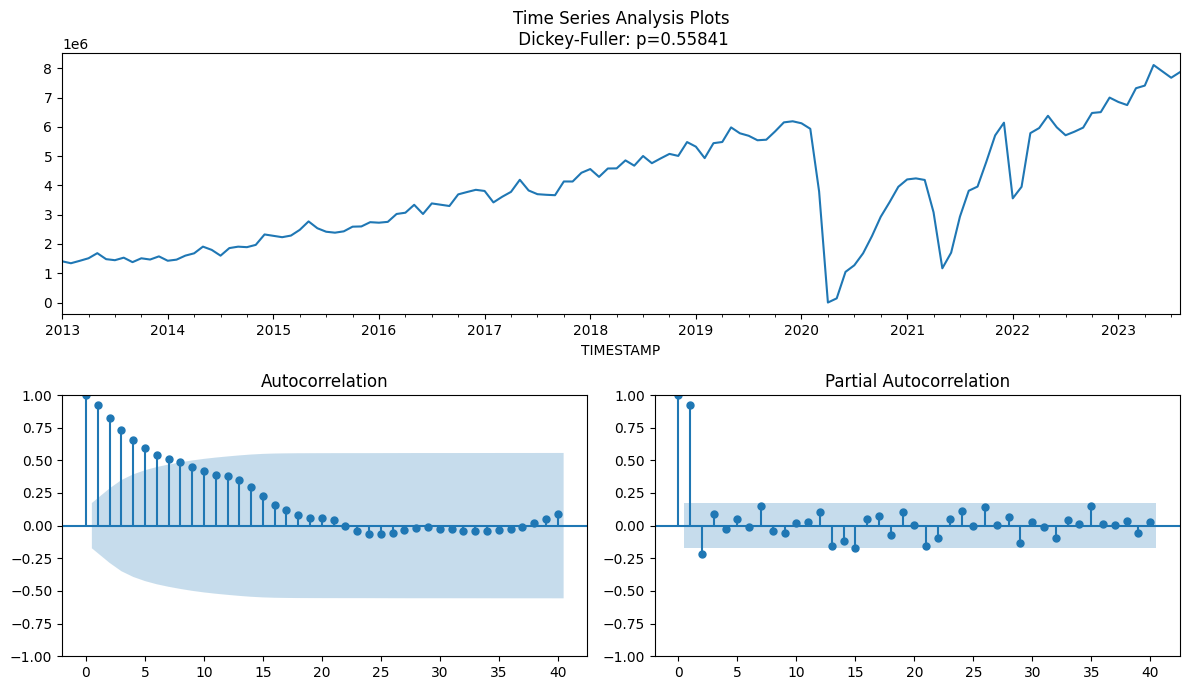

In [3559]:
tsplot(data['PASSENGERS CARRIED'], lags=40)

In [3560]:
# This can interpolate the missing values during COVID in the data
# But this is bad in prediction since we're not incorporating information due to COVID

# data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].where(~(data['COVID PERIOD']), np.nan)
# data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].ffill() 
# 
# decomposition = seasonal_decompose(data['PASSENGERS CARRIED'], model='additive', period=12)
# seasonal = decomposition.seasonal
# trend = decomposition.trend
# residual = decomposition.resid
# 
# seasonal_interpolated = seasonal.where(~(data['COVID PERIOD']), np.nan).interpolate(method='time')
# data['PASSENGERS CARRIED'] = trend + seasonal_interpolated + residual
# 
# plt.figure(figsize=(12, 7))
# plt.plot(data.index, data['PASSENGERS CARRIED'])
# plt.grid(True)
# plt.show()

## Preprocessing the Data

Our data has
* **Trend**
* **Seasonality** (3 months)
* **Varying variance**

To remove varying variance I take `log` of the data, then take difference with lag 3 to remove seasonality

After this, I'm finally plotting the data to see how it looks


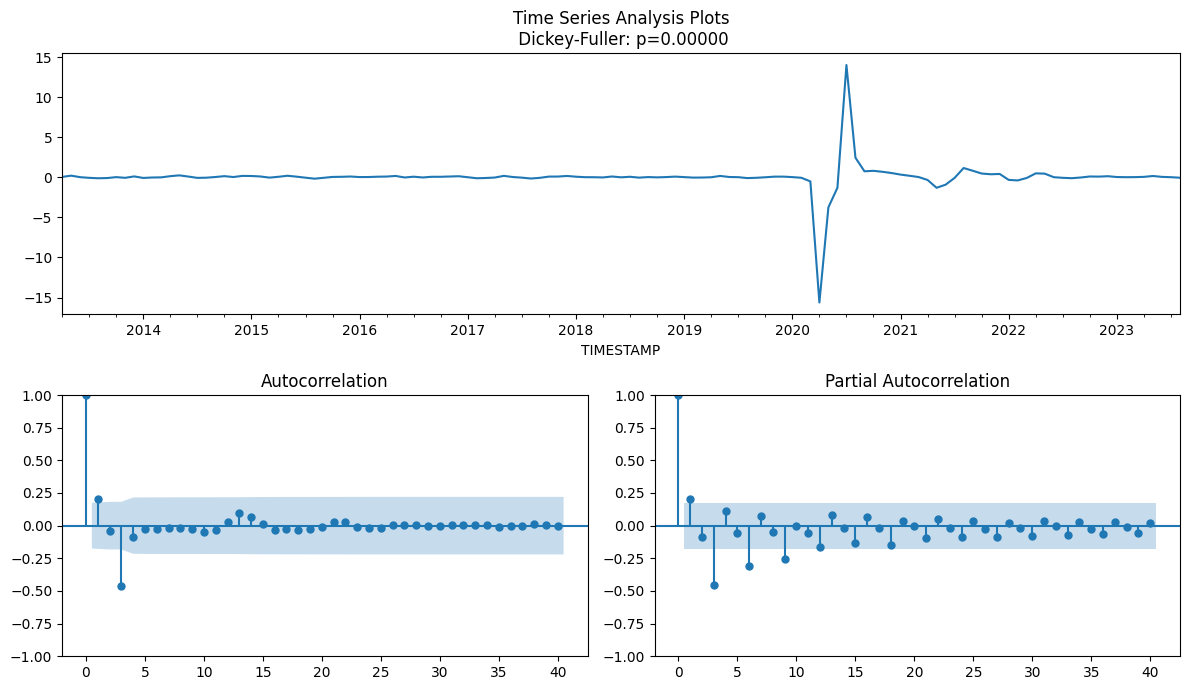

In [3561]:
data['LOG_PASSENGERS'] = np.log(data['PASSENGERS CARRIED'].apply(lambda x: x+1 if x == 0 else -x if x < 0 else x))
season = 3
data['FIRST_DIFF'] = data['LOG_PASSENGERS'].diff(periods=season)
data['DIFF_PASSENGERS'] = data['FIRST_DIFF']
data.dropna(inplace=True)

tsplot(data['DIFF_PASSENGERS'], lags=40)

## Training  a Model
Since the data is sorted according to `TIMESTAMP`, let's **split it into training and testing data**


In [3562]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

Since there's a clear seasonality, let's add a **SARIMA** (seasonal ARIMA) model.

I'm using the **parameters** which can by easily deduced using **ACF** and **PACF** plots of the preprocessed data

Also **applying** the model on the **testing set** we create to evaluate errors (MASE and MAPE)

MAE: 0.243807680107429, MAPE: 1.0792318604875724


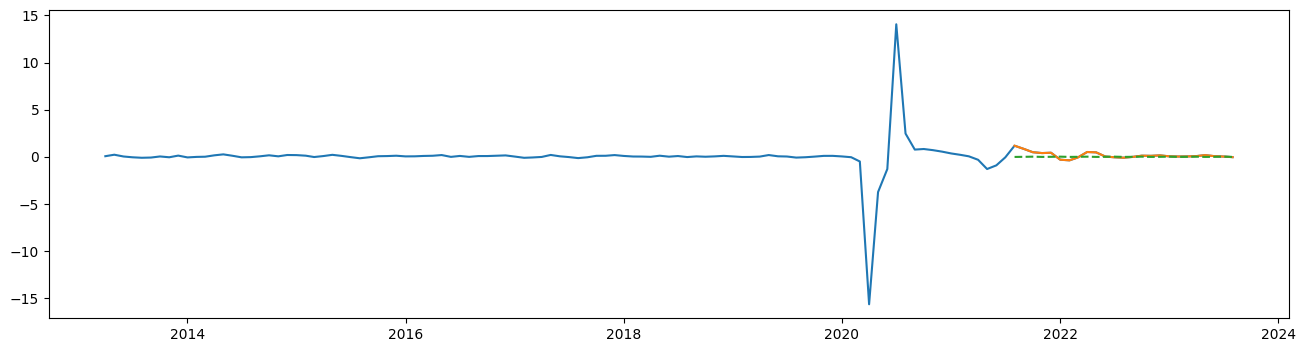

In [3563]:
# just to suppress warnings dw
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", message="Non-invertible starting seasonal moving average")

model = SARIMAX(train['DIFF_PASSENGERS'], order=(1, 0, 1), seasonal_order=(0, 1, 1, season), freq='MS')
sarima_fit = model.fit(disp=False)

predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

mae = mean_absolute_error(test['DIFF_PASSENGERS'], predictions)
mape = mean_absolute_percentage_error(test['DIFF_PASSENGERS'], predictions)
print(f'MAE: {mae}, MAPE: {mape}')

plt.figure(figsize=(16, 4))
plt.plot(data['DIFF_PASSENGERS'], label='Train')
plt.plot(test.index, test['DIFF_PASSENGERS'], label='Test')
plt.plot(test.index, predictions, label='Predictions', linestyle='--')

Finally, we solve the question! Predicting the number of PASSENGERS CARRIED from 2023 September to 2024 August. Since we added some preprocessing to our data, we need to reverse it. Here are the things we did
* Took `log` of the data
* Took difference with lag 3 (`season`)

So I first reverse the difference by adding data at 3 values before. Then I reverse the `log` by taking `exp` of the data.

In [3564]:
data_range = pd.date_range(start='2023-09-01', end='2024-08-01', freq='MS')
future_data = pd.DataFrame(index=data_range, columns=['PASSENGERS CARRIED'])

predicted_diffs = sarima_fit.predict(start=len(data), end=len(data) + len(data_range) - 1, dynamic=False)

last_log_val12 = data['LOG_PASSENGERS'].iloc[-season:]
level_12_diff_reversed = []

for i, pred in enumerate(predicted_diffs):
    if i < season:
        value = pred + last_log_val12.iloc[-season + i]
    else:
        value = pred + level_12_diff_reversed[i - season]
    level_12_diff_reversed.append(value)
    
future_data['PASSENGERS CARRIED'] = [int(np.exp(x) - 1) for x in level_12_diff_reversed]

future_data['YEAR_MONTH'] = future_data.index.strftime('%Y %b').str.upper()
future_data.to_csv('Future.csv')
future_data = future_data[['YEAR_MONTH', 'PASSENGERS CARRIED']]
future_data.to_csv('Future.csv')
future_data.head(14)

,YEAR_MONTH,PASSENGERS CARRIED
2023-09-01,2023 SEP,7937644
2023-10-01,2023 OCT,7842316
2023-11-01,2023 NOV,7834033
2023-12-01,2023 DEC,7982242
2024-01-01,2024 JAN,8013396
2024-02-01,2024 FEB,7800949
2024-03-01,2024 MAR,8027090
2024-04-01,2024 APR,8188208
2024-05-01,2024 MAY,7768004
2024-06-01,2024 JUN,8072191


I am finally plotting our predictions wrt to the original data to get the **feel** of how well we have predicted.

<function matplotlib.pyplot.show(close=None, block=None)>

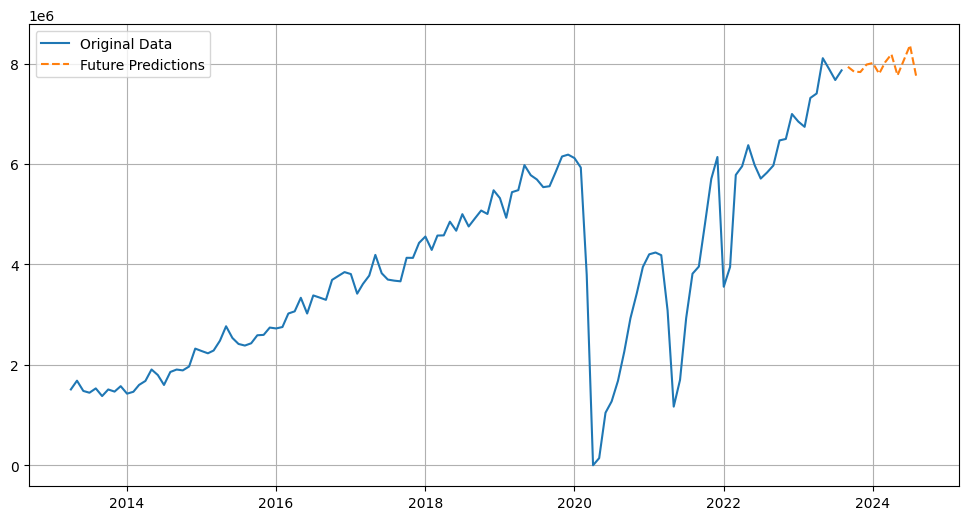

In [3565]:
combined_data = pd.concat([data['PASSENGERS CARRIED'], future_data['PASSENGERS CARRIED']])

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['PASSENGERS CARRIED'], label='Original Data')
plt.plot(future_data.index, future_data['PASSENGERS CARRIED'], label='Future Predictions', linestyle='--')
plt.legend()
plt.grid(True)
plt.show